In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15, 'lines.linewidth': 3, 'savefig.dpi': 1200})
colors = plt.get_cmap('Dark2').colors

import os, random, time, pickle, torch
import numpy as np

store_dir, datasets_dir = 'store', 'vision_datasets'
export_dir = os.path.join(store_dir, 'models', 'exported')
if not os.path.exists(export_dir):
    os.makedirs(export_dir)
figs_dir = os.path.join(store_dir, 'figs')
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

In [2]:
from blurnet import trainer

train_job = trainer.TrainJob(store_dir, datasets_dir)
train_job.results.pth_len = 4

In [3]:
task, grayscale = 'CIFAR10', True
export_pths = {}
sigmas = {
    'baseline': None,
    'blur': 1.5,
}

for label, sigma in sigmas.items():
    cond = {'model_config': {'task': task, 'grayscale': grayscale, 'sigma': sigma}}
    export_pths[label] = []
    for key, config in train_job.conditioned(cond):
        if key not in train_job.results:
            continue
        export_pth = os.path.join(export_dir, '{}-{}-{}-{:03d}.pt'.format(
            task, 'G' if grayscale else 'R',
            'baseline' if sigma is None else '{:g}'.format(sigma),
            config['train_config']['seed']
        ))
        if not os.path.exists(export_pth):
            train_job.export(key, export_pth)
        export_pths[label].append(export_pth)
    print('{} models exported for sigma={}'.format(len(export_pths[label]), sigma))

10 models exported for sigma=None
10 models exported for sigma=1.5


In [4]:
groups = [
    ('baseline', export_pths['baseline'], colors[0]),
    ('blur', export_pths['blur'], colors[2]),
]

In [5]:
from roarena.corruption import CorruptionJob

corrupt_job = CorruptionJob(store_dir, datasets_dir)
accs_corrupt = []
for _, _model_pths, _ in groups:
    _accs = corrupt_job.summarize(_model_pths)
    accs_corrupt.append(_accs)

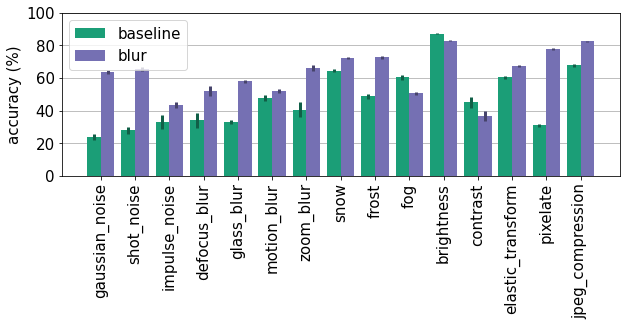

In [6]:
fig, ax = plt.subplots(figsize=(10, 3))
corrupt_job.plot_comparison(ax, groups, accs_corrupt)
plt.show()
fig.savefig(os.path.join(figs_dir, 'common.corruption.svg'))

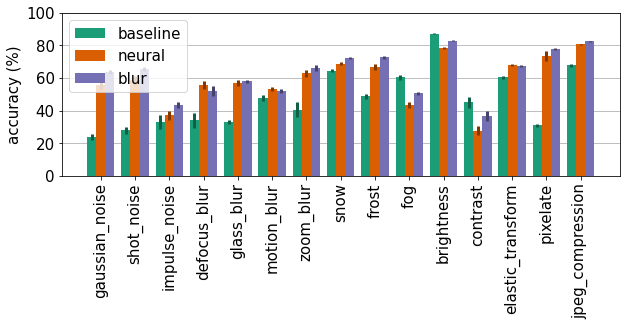

In [7]:
with open('corruption.pickle', 'rb') as f:
    saved = pickle.load(f)
_groups = [
    ('baseline', export_pths['baseline'], colors[0]),
    ('neural', [], colors[1]),
    ('blur', export_pths['blur'], colors[2]),
]
_accs_corrupt = [accs_corrupt[0], saved[1], accs_corrupt[1]]

fig, ax = plt.subplots(figsize=(10, 3))
corrupt_job.plot_comparison(ax, _groups, _accs_corrupt)
plt.show()
fig.savefig(os.path.join(figs_dir, 'common.corruption.svg'))

In [8]:
from roarena.attack import AttackJob

attack_job = AttackJob(store_dir, datasets_dir)
dist_percentiles = {
    'L2': [],
    'LI': [],
}
for _, _model_pths, _ in groups:
    for metric in ['L2', 'LI']:
        _, _dist_percentiles = attack_job.summarize(_model_pths, metric=metric, max_batch_num=10)
        dist_percentiles[metric].append(_dist_percentiles)

/foolbox/foolbox/attacks/brendel_bethge.py:624: UserWarning: At the first initialisation the optimizer needs to be compiled. This may take between 20 to 60 seconds.
  warnings.warn(


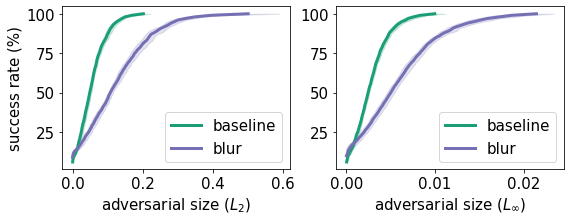

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
for ax, metric in zip(axes, ['L2', 'LI']):
    attack_job.plot_comparison(ax, groups, dist_percentiles[metric])
    ax.set_xlabel(r'adversarial size ({})'.format(r'$L_2$' if metric=='L2' else r'$L_\infty$'))
axes[1].set_ylabel(None)
plt.show()
fig.savefig(os.path.join(figs_dir, 'adv.robustness.svg'))

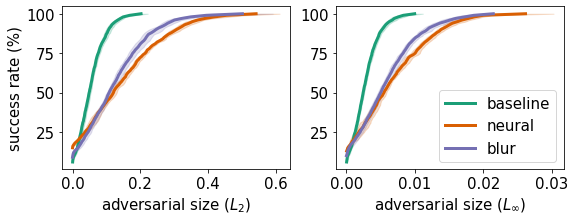

In [10]:
with open('adversarial.pickle', 'rb') as f:
    saved = pickle.load(f)
_groups = [
    ('baseline', export_pths['baseline'], colors[0]),
    ('neural', [], colors[1]),
    ('blur', export_pths['blur'], colors[2]),
]
_dist_percentiles = {
    'L2': [dist_percentiles['L2'][0], saved['L2'][1], dist_percentiles['L2'][1]],
    'LI': [dist_percentiles['LI'][0], saved['LI'][1], dist_percentiles['LI'][1]],
}

fig, axes = plt.subplots(1, 2, figsize=(9, 3))
for ax, metric in zip(axes, ['L2', 'LI']):
    attack_job.plot_comparison(ax, _groups, _dist_percentiles[metric])
    ax.set_xlabel(r'adversarial size ({})'.format(r'$L_2$' if metric=='L2' else r'$L_\infty$'))
axes[0].get_legend().remove()
axes[1].set_ylabel(None)
plt.show()
fig.savefig(os.path.join(figs_dir, 'adv.robustness.svg'))